<a href="https://colab.research.google.com/github/Luke-Williams-01/Luke-Williams-01/blob/main/ICRARproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy import stats

In [2]:
! wget -q https://xgass.icrar.org/assets/data/xGASS_representative_sample.ascii

In [3]:
# Loading the xGASS dataset with specific columns selected
xGASStb= np.loadtxt('xGASS_representative_sample.ascii', dtype = 'float', usecols=[8,9,10,16,18,1,23,24,26,27,31,32], unpack= 'true')
# Loading the specfic columns with flags as separate arrays
HIsrc, HI_FLAG = np.loadtxt('xGASS_representative_sample.ascii', dtype = 'float', usecols=[26,27], unpack= 'true')
# Removing data with an index that falls into the conditions HI_FLAG >1 or HI_FLAG <90
xGASSRd = np.delete(xGASStb, np.where((HI_FLAG >1) & (HI_FLAG < 90)), axis = 1)
xGASST = xGASSRd.T

# Assigning the 1d arrays to the correct column of data
zSDSS = xGASST[:,0]
Dlum = xGASST[:,1]
lgMstar = xGASST[:,2]
petro90r = xGASST[:,3]
lgmust = xGASST[:,4]
lgSFR_tot_median = xGASST[:,5]
SFR_best = xGASST[:,6]
SFRerr_best = xGASST[:,7]
HIsrc = xGASST[:,8]
HI_FLAG = xGASST[:,9]
lgMHI = xGASST[:,10]
lgGF = xGASST[:,11]

In [4]:
# Testing to ensure the correct arrays are filled with the correct values
print(zSDSS)
print(Dlum)
print(lgMstar)
print(petro90r)
print(lgmust)
print(lgSFR_tot_median)
print(SFR_best)
print(SFRerr_best)
print(HIsrc)
print(HI_FLAG)
print(lgMHI)
print(lgGF)

[0.03618 0.03573 0.04201 ... 0.04656 0.02704 0.03797]
[159.2 157.2 185.7 ... 206.5 118.2 167.3]
[10.709 10.539 10.625 ... 10.946 10.334 10.25 ]
[10.51  9.96  7.01 ... 13.09  6.66 14.09]
[9.18 9.05 9.32 ... 9.08 9.37 8.12]
[101866. 101874. 101876. ... 332851. 332201. 332883.]
[0.82985944 0.03869768 0.0620131  ... 2.902701   0.03280856 0.93741816]
[0.         0.07982571 0.15414698 ... 0.42542186 0.         0.28900966]
[3. 4. 3. ... 4. 4. 3.]
[ 1. 99.  1. ... 99. 99.  1.]
[9.603 8.74  9.244 ... 9.183 8.664 9.517]
[-1.106 -1.799 -1.381 ... -1.763 -1.67  -0.733]


In [5]:
# Finding all the rows in the xGASS data with HIsrc < 4, if HIsrc = 4, no detection of HI
HIndet = np.where(HIsrc >= 4)[0]

lgMstar1 = np.delete(lgMstar, (HIndet))
lgmust1 = np.delete(lgmust, (HIndet))
lgSFR_tot_median1 = np.delete(lgSFR_tot_median, (HIndet))
SFR_best1 = np.delete(SFR_best, (HIndet))
SFRerr_best1 = np.delete(SFRerr_best, (HIndet))
HIsrc1 = np.delete(HIsrc, (HIndet))
HI_FLAG1 = np.delete(HI_FLAG, (HIndet))
lgMHI1 = np.delete(lgMHI, (HIndet))
lgGF1 = np.delete(lgGF, (HIndet))

HIdet = np.where(HIsrc < 4)[0]

lgMstar2 = np.delete(lgMstar, (HIdet))
lgmust2 = np.delete(lgmust, (HIdet))
lgSFR_tot_median2 = np.delete(lgSFR_tot_median, (HIdet))
SFR_best2 = np.delete(SFR_best, (HIdet))
SFRerr_best2 = np.delete(SFRerr_best, (HIdet))
HIsrc2 = np.delete(HIsrc, (HIdet))
HI_FLAG2 = np.delete(HI_FLAG, (HIdet))
lgMHI2 = np.delete(lgMHI, (HIdet))
lgGF2 = np.delete(lgGF, (HIdet))

print(len(lgMstar))
print(len(lgMstar1))
print(len(lgMstar2))

1066
691
375


In [6]:
# Finding the running median of the HI detections
# Array for the bin start, stop and range
bins = np.linspace(9, 11, 100)

# Array of zeroes to store the median of each bin
mHI = np.zeros(100)
median1 = np.zeros(100)

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins) -1):
  median1[i] = np.median(lgMHI1[np.where((lgMstar1 >= bins[i]) & (lgMstar1 <= bins[i+1]))])
  mHI[i] = median1[i]
print(mHI[0:98])

# Finding the running median of the Mstar

# Array of zeroes to store the median of each bin
mstar = np.zeros(100)
median2 = np.zeros(100)

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins) -1):
  median2[i] = np.median(lgMstar1[np.where((lgMHI1 >= bins[i]) & (lgMHI1 <= bins[i+1]))])
  mstar[i] = median2[i]
print(mstar)

[ 8.97    9.21    9.31    8.767   9.17    8.802   8.896   9.225   9.0605
  9.151   9.04    9.215   9.137   9.515   9.01    9.129   9.75    9.5
  9.63    9.335   9.3755  9.225   9.155   9.413   9.2955  9.33    8.692
  9.53    9.7     8.951   9.4     9.3285  9.043   9.47    9.455   9.2305
  9.48    9.335   9.69    9.16    9.      9.53    9.3465  9.45    9.375
  9.495   9.87    9.96    9.36    9.637   9.0355  9.5495  9.357   9.57
  9.5175  9.7365  9.3985  9.5     9.74    9.383   9.251   9.517   9.546
  9.4485  9.596   9.706   9.448   9.469   9.5255  9.027   9.72    9.411
  9.337   9.577   9.425   9.7245  9.813   9.4335  9.658   9.516   9.5665
  9.681   9.67    9.972   9.77    9.96    9.5845  9.935   9.857   9.83
  9.8805 10.085   9.72    9.81    9.97    9.866   9.95    9.595 ]
[ 9.80083075 10.012      10.023464   10.174344   10.042       9.780929
  9.885124    9.2195215   9.916551   10.2027595   9.749454   10.2155
 10.204      10.149       9.931487   10.194377   10.297       9.88976
 10.2

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


"\nplt.subplot(223)\nplt.plot(,, 'k.', label= 'HI detection')\nplt.plot(,, 'r.', label= 'No HI detection')\nplt.xlabel('log(M*) [M$_{solar}$]')\nplt.ylabel('log(M$_{HI}$)')\n\nplt.subplot(224)\nplt.plot(,, 'k.', label= 'HI detection')\nplt.plot(,, 'r.', label= 'No HI detection')\nplt.xlabel('log(SFR) [M$_{solar}$ yr$^{-1}$]')\nplt.ylabel('log(M$_{HI}$)')\n"

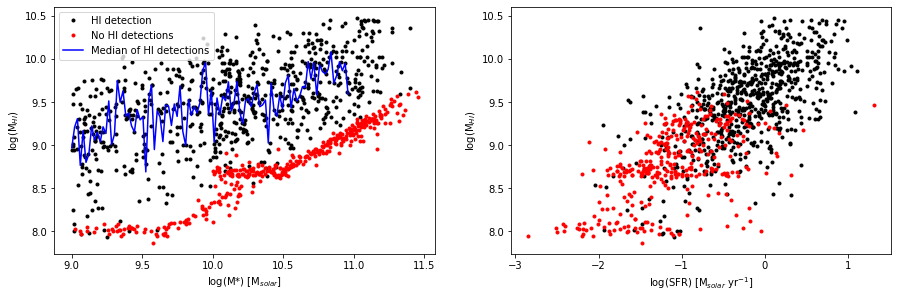

In [7]:
# Global HI mass and HI mass contained in the optical regions
plt.figure(figsize = (15,10))

plt.subplot(221)
plt.plot(lgMstar1, lgMHI1, 'k.', label= 'HI detection')
plt.plot(lgMstar2, lgMHI2, 'r.', label= 'No HI detections')
plt.plot(bins[0:98], mHI[0:98], 'b-', label = 'Median of HI detections')
plt.xlabel('log(M*) [M$_{solar}$]')
plt.ylabel('log(M$_{HI}$)')
plt.legend(loc='upper left')

plt.subplot(222)
plt.plot(np.log10(SFR_best1), lgMHI1, 'k.', label= 'HI detection')
plt.plot(np.log10(SFR_best2), lgMHI2, 'r.', label= 'No HI detection')
plt.xlabel('log(SFR) [M$_{solar}$ yr$^{-1}$]')
plt.ylabel('log(M$_{HI}$)')
'''
plt.subplot(223)
plt.plot(,, 'k.', label= 'HI detection')
plt.plot(,, 'r.', label= 'No HI detection')
plt.xlabel('log(M*) [M$_{solar}$]')
plt.ylabel('log(M$_{HI}$)')

plt.subplot(224)
plt.plot(,, 'k.', label= 'HI detection')
plt.plot(,, 'r.', label= 'No HI detection')
plt.xlabel('log(SFR) [M$_{solar}$ yr$^{-1}$]')
plt.ylabel('log(M$_{HI}$)')
'''

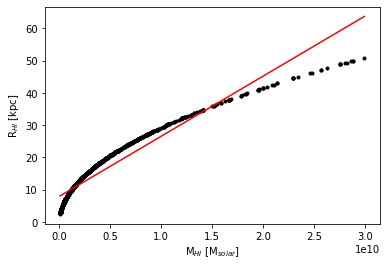

In [8]:
# DHI- MHI relation
lgDHI = 0.506*lgMHI - 3.293
MHI = 10**lgMHI
DHI = 10**lgDHI
RHI = 0.5*DHI

# Plotting the R(HI)-M(HI) relation
plt.figure()
plt.plot(MHI, RHI, 'k.')
plt.ylabel('R$_{HI}$ [kpc]')
plt.xlabel('M$_{HI}$ [M$_{solar}$]')


# Fitting a line to the RHI-MHI relation
x = MHI
p = np.linspace(min(MHI), max(MHI), 1000)
y = RHI
def linfun(x, m, c): 
    return m*x + c
p0 = np.array([])
popt, pcov = curve_fit(linfun, x, y)

# plot fit
plt.plot(p, linfun(p, *popt), 'r')


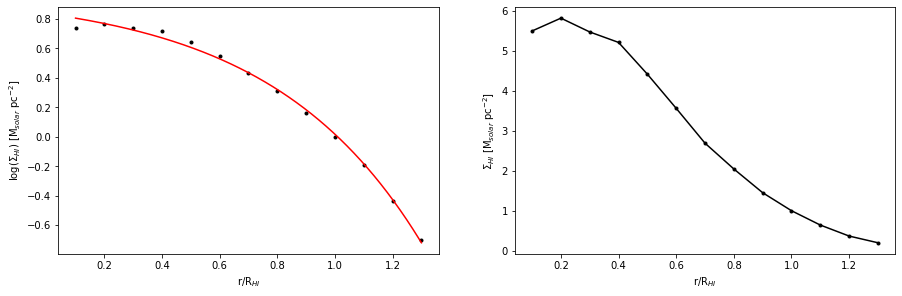

In [9]:
# Need to create a median HI profile of galaxies- (data from Wang et al 2020)

rrHI=np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3])
SigHI=np.array([5.50455,5.82575,5.47971,5.21774,4.42226,3.56687,2.69376,2.04850,1.45364,1.00281,0.643707,0.368113,0.2])
lgSigHI = np.log10(SigHI)


# Plotting the median HI profile using Wang 2020 data
plt.figure(figsize = (15,10))
plt.subplot(221)
plt.plot(rrHI, lgSigHI, 'k.')
plt.xlabel('r/R$_{HI}$')
plt.ylabel('log(Σ$_{HI}$) [M$_{solar}$ pc$^{-2}$]')

# Noticable data 'gap' from 0 - 0.1 RHI
# Fitting a curve to the data will allow a different range to be set
x = rrHI
p = np.linspace(min(rrHI), max(rrHI), 1000)
y = lgSigHI
def curvefun(x, a, b, c, d): 
    return -a*np.exp((x*b)- c) + d  
p0 = np.array([1,1,1,1])
popt, pcov = curve_fit(curvefun, x, y, p0)

# plot fit
plt.plot(p, curvefun(p, *popt), 'r')

plt.subplot(222)
plt.plot(rrHI, SigHI, 'k.-')
plt.xlabel('r/R$_{HI}$')
plt.ylabel('Σ$_{HI}$ [M$_{solar}$ pc$^{-2}$]');




In [10]:
# Convert the petrosian flux r band (90%) from arcsec to parsec
r90 = 1/petro90r
print(min(r90), max(r90))
# Normalise r90 by dividing by RHI
r90norm = r90/RHI
print(min(r90norm), max(r90norm))

# Finding the running median for the HI profile
# Array for the bin start, stop and range
bins = np.linspace(min(r90norm), max(r90norm), 13)

# Array of zeroes to store the median of each bin
mHI = np.zeros(100)
medn = np.zeros(100)
'''
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins) -1):
  medn1[i] = np.median(lgMHI1[np.where((lgMHI1 >= bins[i]) & (lgMHI1 <= bins[i+1]))])
  mHI[i] = medn[i]
print(mHI)
'''

0.02685284640171858 0.4716981132075471
0.0007925123764128669 0.08955046237395657


'\n# Using a for loop to iterate over the median values for each of the bins\nfor i in range(len(bins) -1):\n  medn1[i] = np.median(lgMHI1[np.where((lgMHI1 >= bins[i]) & (lgMHI1 <= bins[i+1]))])\n  mHI[i] = medn[i]\nprint(mHI)\n'